In [2]:
import duet
import numpy as real_numpy
from duet import pandas as pd
from duet import numpy as np
from duet import map 
from duet import L2 
from duet import LInf 
from duet import zip 
import matplotlib.pyplot as plt
import urllib.request
import os

In [3]:
epsilon = 1.0
alpha = 10 

if not os.path.exists('../data_long/'):
    os.makedirs('../data_long/')

if not os.path.exists('../data_long/adult_processed_x.npy'):
    urllib.request.urlretrieve('https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy',
                               '../data_long/adult_processed_x.npy')
    urllib.request.urlretrieve('https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy',
                               '../data_long/adult_processed_y.npy')

X = np.load('../data_long/adult_processed_x.npy')
y = np.load('../data_long/adult_processed_y.npy')

## Training A Model with Gradient Descent<a name="training"></a>

The goal for training this algorithm is to minimize the loss on the training data, while preserving differential privacy. We split the data into 80% training data and 20% testing data.

In [4]:
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

## Computing the Gradient<a name="gradient"></a>

Gradient descent is an approach to minimize the loss using the gradient (multi-dimensional derivative) of the loss function. Below, we define the gradient `vgradient`, vectorized over numpy arrays.

In [14]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    clipped_grads = L2_clip_array(gradients, C)
    return np.sum(clipped_grads, axis = 0)

## Bounding Sensitivity by Clipping<a name="clipping"></a>

The `L2_clip_array` function takes an array in which each row has unbounded sensitivity, and returns one where every row has bounded *L2 sensitivity*. This is a common approach for bounding global sensitivity in machine learning applications, where the gradient function may not have bounded sensitivity. We use the `duet.mode_switch` decorator to tell DDuo about `L2_clip_array`'s effect on sensitivity.

In [16]:
@duet.mode_switch(LInf, L2)
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

def accuracy(theta):
    return np.sum(predict(theta, X_test) == y_test)/X_test.shape[0]

def predict(theta, xi):
    label = np.sign(xi @ theta)
    return label

## Differential Privacy Gradient Descent<a name="differentialprivacy"></a>

The gradient descent algorithm repeatedly computes the gradient, uses the Gaussian mechanism to ensure differential privacy, and updates the model.

In [19]:
def dp_gradient_descent(iterations, alpha, epsilon):
    eps_i = epsilon/iterations
    theta = np.zeros(X_train.shape[1].val)  # leaks the number of features, without privacy
    clipping_param = 5
    num_examples = X_train.shape[0].val     # leaks the number of training examples, without privacy
    for i in range(iterations):
        grad_sum        = vgradient(theta, X_train, y_train, clipping_param)
        noisy_grad_sum  = duet.renyi_gauss_vec(grad_sum, alpha=alpha, epsilon=eps_i)
        noisy_avg_grad  = noisy_grad_sum / num_examples
        theta           = theta - noisy_avg_grad

    return theta

alpha = 20
epsilon = .001
with duet.RenyiOdometer((alpha, 2*epsilon)) as odo:
    print('Accuracy:', accuracy(dp_gradient_descent(20, alpha, epsilon)).val)
    print('Privacy cost:', odo)

Accuracy: 0.8032950022114109
Privacy cost: (20, 0.0030000000000000027)


## Effect of Privacy on Accuracy<a name="trainingeffect"></a>

To see the effect of privacy on accuracy, we train models with a variety of epsilon values and graph their accuracies. Smaller values of $\epsilon$ yield higher privacy, but lower accuracy. The graph is jagged instead of smooth, because we run only a single trial for each value of $\epsilon$ - in a real experiment, we'd run multiple trials and take the average accuracy, to account for the nondeterminism of the privacy mechanism.

In [25]:
with duet.RenyiOdometer((alpha, 2*epsilon)) as odo:
    epsilons = [0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.003, 0.005, 0.008, 0.01]
    thetas   = [dp_gradient_descent(10, alpha, epsilon) for epsilon in epsilons]
    accurate = [accuracy(theta).val for theta in thetas]  # leaks the accuracies, with no privacy
    print('Total privacy cost:', odo)

Total privacy cost: (20, 0.030700000000000012)


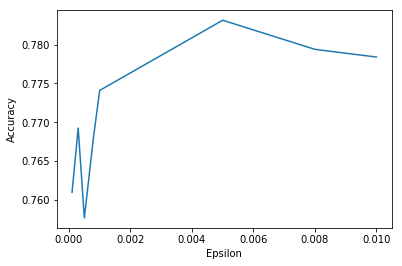

In [26]:
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.plot(epsilons, accurate);